# Basic strategy - Q learning, SARSA, Monto carlo

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from collections import defaultdict
import time
import optuna

C:\Users\anagh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Black jack environment

In [2]:

class BlackjackEnvironment:
   def __init__(self):
         """
         A simplified Blackjack environment with improved reward signals
         for actions: Hit (h), Stand (s), and Double Down (d).
         """
         self.deck = self._create_new_deck()
         self.player_cards = []
         self.dealer_cards = []
         self.has_doubled_down = False
         self.game_over = False
         
         # Tracking rewards 
         self.rewards = []
         
         
         # Initialize / reset the game at the start
         self.reset_game()

   def _create_new_deck(self):
         """
         Creates a fresh deck of 52 cards:
            - Values: 2..10, Jack, Queen, King, Ace
            - Suits: hearts, diamonds, clubs, spades
         """
         suits = ['hearts', 'diamonds', 'clubs', 'spades']
         values = list(range(2, 11)) + ['jack', 'queen', 'king', 'ace']
         deck = [f"{value}_{suit}" for value in values for suit in suits]
         random.shuffle(deck)
         return deck

   def _draw_random_card(self):
         """
         Pops a card randomly from the current deck.
         """
         return self.deck.pop()

   def reset_game(self):
         """
         Resets the environment for a new round of Blackjack:
      
         """
         self.deck = self._create_new_deck()
         self.player_cards = [self._draw_random_card(), self._draw_random_card()]
         self.dealer_cards = [self._draw_random_card(), self._draw_random_card()]
         
         self.has_doubled_down = False
         self.game_over = False

   def _get_card_value(self, card):
         """
         Extracts the numeric value from the card string.
         J, Q, K = 10 points
         Ace = 11 points by default 
         """
         value = card.split('_')[0]
         if value in ['jack', 'queen', 'king']:
               return 10
         elif value == 'ace':
               return 11
         else:
               return int(value)

   def _calculate_hand_value(self, hand):
         """
         Calculates the total value of a given hand, taking into account
         the possibility of using Ace as 1 to avoid bust.
         """
         total = sum(self._get_card_value(card) for card in hand)
         # Adjust for Aces if we're over 21
         aces = sum(card.startswith('ace') for card in hand)
         
         while total > 21 and aces > 0:
               total -= 10
               aces -= 1
         return total

   def _has_soft_hand(self, hand):
         """
         Checks if the hand is 'soft' (i.e., contains an Ace counted as 11).
         """
         # If adding an Ace as 11 didn't cause a reduction, then it's soft
         total_without_ace_adjust = sum(
               1 if card.startswith('ace') else self._get_card_value(card)
               for card in hand
         )
         total = self._calculate_hand_value(hand)
         return (total != total_without_ace_adjust)

   def _check_if_busted(self, hand):
         """
         Returns True if the hand value exceeds 21, otherwise False.
         """
         return self._calculate_hand_value(hand) > 21

   def _check_natural_blackjack(self, hand):
         """
         Checks for a natural Blackjack: exactly 2 cards that sum to 21.
         """
         return len(hand) == 2 and self._calculate_hand_value(hand) == 21

   def _play_dealer_hand(self):
         """
         Dealer hits until total is 17 or more.
         """
         while self._calculate_hand_value(self.dealer_cards) < 17:
               self.dealer_cards.append(self._draw_random_card())

   def _finalize_round(self):
         """
         Compares player's hand vs. dealer's hand to assign final rewards.
         Returns: (state, reward, done)
         """
         player_value = self._calculate_hand_value(self.player_cards)
         dealer_value = self._calculate_hand_value(self.dealer_cards)

         # Dealer bust check
         if self._check_if_busted(self.dealer_cards):
               # Player automatically wins
               reward = 2 if self.has_doubled_down else 1
               self.rewards.append(reward)
               
               return 'terminal', reward, True

         # Compare final values
         if player_value > dealer_value:
               # Player wins
               reward = 2 if self.has_doubled_down else 1
         elif player_value < dealer_value:
               # Dealer wins
               reward = -2 if self.has_doubled_down else -1
         else:
               # Tie
               reward = 0

         # Logging
         self.rewards.append(reward)

         return 'terminal', reward, True

   def get_current_state(self):
         """
         Returns a representation of the current state for an RL agent:
         """
         player_value = self._calculate_hand_value(self.player_cards)
         dealer_up_card_value = self._get_card_value(self.dealer_cards[0])
         is_soft = self._has_soft_hand(self.player_cards)
         return (player_value, dealer_up_card_value, is_soft, self.has_doubled_down)

   def step(self, action):
         """
         Executes the given action
         Returns: (next_state, reward, done)
         """
         if self.game_over:
               # If the game is already over, no further actions can be taken
               return 'terminal', 0, True
         if self._check_natural_blackjack(self.player_cards):
               reward = 1.5
               self.rewards.append(reward)
               self.game_over = True
               return 'terminal', reward, True

         if action == 'h':
               # Player hits
               self.player_cards.append(self._draw_random_card())
               if self._check_if_busted(self.player_cards):
                  # Player busts = immediate negative reward
                  reward = -2 if self.has_doubled_down else -1
                  self.rewards.append(reward)
                  self.game_over = True
                  return 'terminal', reward, True
               else:
                  # Still alive, no immediate reward, game not done
                  return self.get_current_state(), 0, False

         elif action == 's':
               # Stand = dealer plays, then finalize
               self._play_dealer_hand()
               next_state, reward, done = self._finalize_round()
               self.game_over = True
               return next_state, reward, done

         elif action == 'd':
               # Double down = bet is doubled, draw 1 card, then stand
               self.has_doubled_down = True
               self.player_cards.append(self._draw_random_card())
               if self._check_if_busted(self.player_cards):
                  # Busted = immediate -2
                  reward = -2
                  self.rewards.append(reward)
                  self.game_over = True
                  return 'terminal', reward, True
               else:
                  # Otherwise, stand after doubling down
                  self._play_dealer_hand()
                  next_state, reward, done = self._finalize_round()
                  self.game_over = True
                  return next_state, reward, done

         else:
               raise ValueError("Invalid action.")


Q learning -RL

In [4]:
#class Qlearning

class QLearningAgent:
      def __init__(self, environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, alpha, gamma):
         # initialize the Q-learning agent with the given environment and learning parameters
         self.environment = environment
         self.alpha = alpha  # learning rate
         self.gamma = gamma  # discount factor
         self.initial_epsilon = initial_epsilon  # exploration rate
         self.epsilon = self.initial_epsilon
         self.num_episodes = num_episodes  # number of episodes to train
         self.epsilon_decay = epsilon_decay  # decay rate for epsilon
         self.final_epsilon = final_epsilon
         self.Q_values = {}  # Q-value dictionary mapping (state, action) pairs to Q-values
         self.epsilon_values = []
         self.epsilon = 0
         self.q_table = {}
         self.action_counts = {'h': 0, 's': 0, 'd': 0}
         

   # Method to extract the policy
      def get_policy(self):
         policy = {}
         for state, actions in self.q_table.items():
               # Find the action with the highest Q-value
               best_action = max(actions, key=actions.get)
               policy[state] = best_action
         return policy
      
      def get_q_table(self):
   
         for (state, action), q_value in self.Q_values.items():
            if state == 'terminal':
                  continue 
            if state not in self.q_table:
                  self.q_table[state] = {}
            self.q_table[state][action] = q_value

         return self.q_table
         


      def get_q_value(self, state, action):
      # get the Q-value for a given state-action pair
            return self.Q_values.get((state, action), 0)
   
      def select_action(self, state):
   
         valid_actions = ['h', 's','d']
         if np.random.random() < self.epsilon:
               action = random.choice(valid_actions)   
         else:
               action = max(valid_actions, key=lambda action: self.Q_values.get((state, action), 0))

         self.action_counts[action] += 1  # Increment the count for the selected action
         return action    

      def update_q_value(self, state, action, next_state, reward):
         # update the Q-value table using the Q-learning update rule
         
         current_q = self.get_q_value(state, action)
         next_q = max(self.get_q_value(next_state, a) for a in ['h', 's','d'])
         temporal_difference = reward + self.gamma * next_q - current_q
         self.Q_values[(state, action)] = current_q + self.alpha * temporal_difference


      
      def decay_epsilon(self,num_episode):

         #exp decay
         
         self.epsilon = max(self.final_epsilon, self.initial_epsilon * (self.epsilon_decay ** num_episode))


   
      def train_agent(self, num_episodes):
         # train the Q-learning agent by running the algorithm for the specified number of episodes
         for episode in range(num_episodes):
               self.environment.reset_game()
               state = self.environment.get_current_state()
               done = False
               while not done:
                  action = self.select_action(state)
                  next_state, reward, done = self.environment.step(action)
                  self.update_q_value(state, action, next_state, reward)
                  state = next_state  
               
               
               self.decay_epsilon(num_episode= episode)  # Decay epsilon after each episode
               self.epsilon_values.append(self.epsilon)
         
      def train_agent_HP(self, num_episodes):
            rewards = []  # Track rewards
            for episode in range(num_episodes):
                  self.environment.reset_game()
                  state = self.environment.get_current_state()
                  done = False
                  while not done:
                        action = self.select_action(state)
                        next_state, reward, done = self.environment.step(action)
                        rewards.append(reward)
                        self.update_q_value(state, action, next_state, reward)
                        state = next_state 
                  self.decay_epsilon(num_episode= episode)
                  self.epsilon_values.append(self.epsilon)
            if rewards:  
                  return sum(rewards) / len(rewards)  # Average reward
            else:
                  return 0.0  # Return a default value if no rewards

      


hyper parameter tuning

In [5]:


# Hyperparameters
num_episodes = 100000
initial_epsilon = 1.0
environment = BlackjackEnvironment()

def objective(trial):
    # Suggest hyperparameters
    final_epsilon = trial.suggest_float("epsilon", 0.05, 0.1, log=True)
    learning_rate = trial.suggest_float("alpha", 0.01, 0.5, log=True)
    discount_factor = trial.suggest_float("gamma", 0.5, 1.0)

    epsilon_decay = (final_epsilon / initial_epsilon) ** (1 / num_episodes)

    # Initialize the Q-learning agent
    agent = QLearningAgent(
        environment=environment,
        num_episodes=num_episodes,
        initial_epsilon=initial_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        alpha=learning_rate,
        gamma=discount_factor,
    )

    # Train the agent and calculate average reward
    average_reward = agent.train_agent_HP(num_episodes)
    return average_reward


start = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
end = time.time()


print("Optimization completed in {:.2f} seconds.".format(end - start))
print("Best parameters:", study.best_params)


[I 2025-01-18 12:53:29,126] A new study created in memory with name: no-name-d77e1704-ea38-4d6d-9948-4970391aeef3
[I 2025-01-18 12:53:39,931] Trial 0 finished with value: -0.17122946919116905 and parameters: {'epsilon': 0.09050895952380356, 'alpha': 0.1146867467168863, 'gamma': 0.9475738671928546}. Best is trial 0 with value: -0.17122946919116905.
[I 2025-01-18 12:53:48,883] Trial 1 finished with value: -0.15542802138101525 and parameters: {'epsilon': 0.07557185612980413, 'alpha': 0.04571470090711503, 'gamma': 0.6932749521892654}. Best is trial 1 with value: -0.15542802138101525.
[I 2025-01-18 12:53:57,472] Trial 2 finished with value: -0.16472643038461823 and parameters: {'epsilon': 0.09159676980415557, 'alpha': 0.02468958101249764, 'gamma': 0.5409214313924204}. Best is trial 1 with value: -0.15542802138101525.
[I 2025-01-18 12:54:06,582] Trial 3 finished with value: -0.1645082903476926 and parameters: {'epsilon': 0.09244957908641906, 'alpha': 0.0796507021535696, 'gamma': 0.5505108027

Optimization completed in 654.94 seconds.
Best parameters: {'epsilon': 0.05205650810936523, 'alpha': 0.022095606128790385, 'gamma': 0.527737516246394}


In [21]:
# training phase
start = time.time()
num_episodes = 100000

learning_rate = 0.022095606128790385
discount_factor =  0.527737516246394

initial_epsilon =  1.0
final_epsilon = 0.05205650810936523
epsilon_decay = (final_epsilon / initial_epsilon) ** (1 / num_episodes)


# Initialize the environment and the Q-learning agent
environment = BlackjackEnvironment()
agent = QLearningAgent(environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, learning_rate, discount_factor)

agent.train_agent(num_episodes)
q_table = agent.get_q_table()
policy = agent.get_policy()


# evaluate the performance of the trained agent over a number of games
num_games = 10000
win_count = 0
loss_count = 0
draw_count = 0
total_reward = 0

for _ in range(num_games):
   
      agent.environment.reset_game()
      state = agent.environment.get_current_state()
      game_done = False

      while not game_done:
         action = agent.select_action(state)
         state, reward, game_done = agent.environment.step(action)
         total_reward += reward
         
      if reward > 0:
         win_count += 1
      elif reward < 0:
         loss_count += 1
      else:
         draw_count += 1

end = time.time()
print(f"Total time: {end-start:0.2f} seconds")
winning_rate = win_count / num_games
losing_rate = loss_count / num_games
draw_rate = draw_count / num_games

print(f"Basic Strategy - QLearning: Winning rate: {winning_rate:.4f}, Losing rate: {losing_rate:.4f}, Draw rate: {draw_rate:.4f}")




Total time: 11.52 seconds
Basic Strategy - QLearning: Winning rate: 0.4248, Losing rate: 0.4883, Draw rate: 0.0869


In [22]:

print(len(policy))
print(policy)

280
{(20, 8, False, False): 's', (8, 6, False, False): 'h', (18, 6, False, False): 's', (16, 7, False, False): 'h', (17, 7, False, False): 's', (10, 3, False, False): 'h', (21, 3, True, False): 'h', (21, 10, True, False): 's', (21, 7, True, False): 'h', (7, 10, False, False): 'h', (14, 10, False, False): 'h', (20, 10, False, False): 's', (11, 9, False, False): 'h', (11, 11, False, False): 'h', (16, 10, False, False): 'h', (13, 10, False, False): 'h', (12, 10, False, False): 'h', (15, 10, False, False): 'h', (11, 10, False, False): 'h', (18, 10, False, False): 's', (15, 7, False, False): 'h', (15, 2, False, False): 's', (10, 5, False, False): 'd', (17, 8, False, False): 's', (14, 2, False, False): 's', (13, 10, True, False): 'h', (12, 7, True, False): 'd', (15, 7, True, False): 'h', (9, 10, False, False): 'h', (5, 5, False, False): 'h', (17, 5, False, False): 's', (10, 10, False, False): 'h', (18, 9, True, False): 'h', (14, 9, False, False): 'h', (20, 11, False, False): 's', (13, 4, Tru

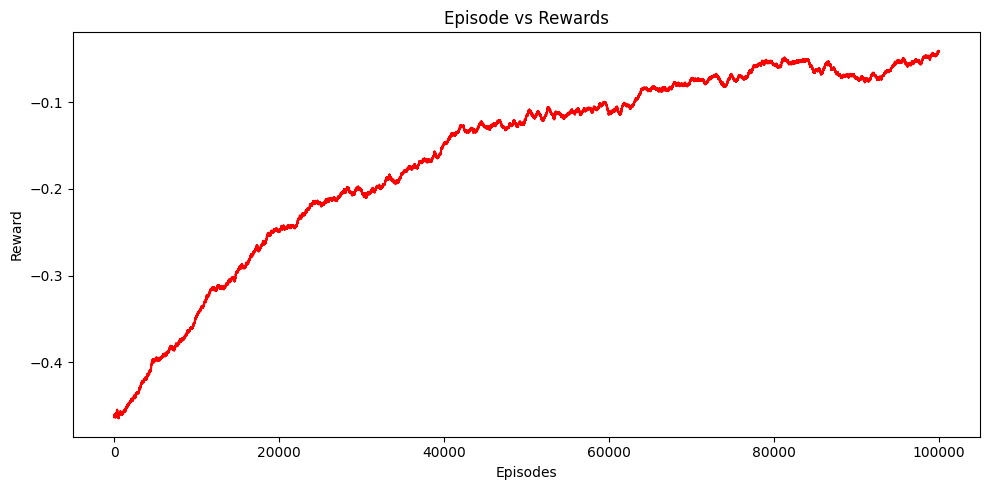

In [23]:


# Plot the reward moving average
length_step = 10000
reward_moving_average = (np.convolve(np.array(agent.environment.rewards).flatten(), np.ones(length_step), mode="valid") / length_step)
plt.figure(figsize=(10, 5))
plt.title('Episode vs Rewards')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(range(len(reward_moving_average)), reward_moving_average, color='red')
plt.tight_layout()
plt.show()

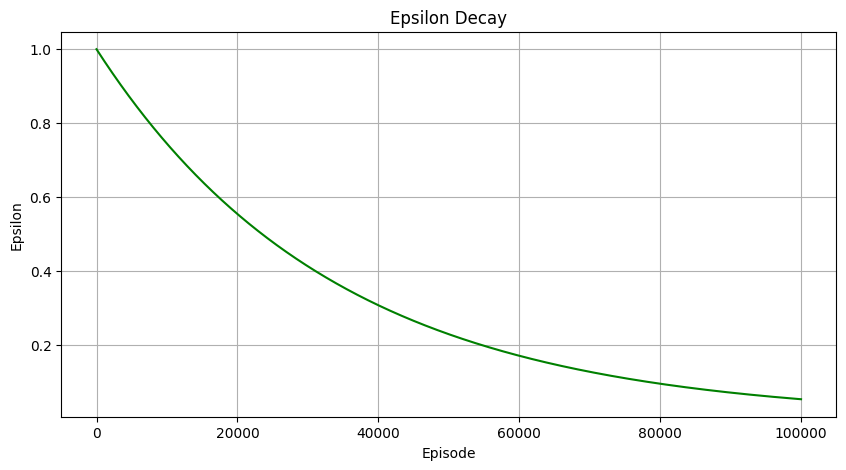

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot epsilon values
ax.plot(range(len(agent.epsilon_values)), agent.epsilon_values, color='green')

# Set labels, title, and grid
ax.set_xlabel('Episode')
ax.set_ylabel('Epsilon')
ax.set_title('Epsilon Decay')
ax.grid()

plt.show()

Q-learning --- rule variations

In [25]:
class QLearningAgent_RV:
    def __init__(self, environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, learning_rate=0.1, discount_factor=0.99):
        
        self.environment = environment
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.initial_epsilon = initial_epsilon
        self.epsilon = initial_epsilon
        self.num_episodes = num_episodes
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.Q_values = defaultdict(lambda: [0, 0,0])
        self.errors = []
        self.epsilon_values = []

        self.q_table = {}
        self.action_map = {'h': 0, 's': 1, 'd': 2}
    

     # Method to extract the policy
    def get_policy(self):
        policy = {}
        for state, actions in self.q_table.items():
            # Find the action with the highest Q-value
            best_action = max(actions, key=actions.get)
            policy[state] = best_action
        return policy
    
     
    def get_q_table(self):
    # Generate a Q-table organized by state and actions
        for state, q_values in self.Q_values.items():
            if state == 'terminal':
               continue 
            if state not in self.q_table:
                self.q_table[state] = {}
            actions = ['h', 's','d'] 
            for action_index, action in enumerate(actions):
                self.q_table[state][action] = q_values[action_index]
        return self.q_table
     
   
    

    def select_action(self, state):
        # choose an action based on the current state
        
    
        if self.environment._has_soft_hand(self.environment.player_cards):
            return self.choose_soft_action(state)
        else: 
            return self.choose_hard_action(state)

    def choose_hard_action(self, state):
      """
      Basic Strategy for Hard Hands (Table 3.1) 
      + Simple Double Down logic.
      """
      player_hand_value = state[0]
      dealer_up_card_value = state[1]
      has_doubled_down = state[3]

      # 1) Check for Double Down opportunities
      #    (In real Blackjack, often limited to two-card totals 9, 10, 11.)
      #    We'll assume we can always double if we meet these totals.
      
      if player_hand_value == 9 and 3 <= dealer_up_card_value <= 6:
            return 'd'
      elif player_hand_value == 10 and 2 <= dealer_up_card_value <= 9:
            return 'd'
      elif player_hand_value == 11 and 2 <= dealer_up_card_value <= 10:
            return 'd'
      
      if player_hand_value <= 11:
         return 'h'
      elif player_hand_value >= 17: 
         return 's'
      elif 12 <= player_hand_value <= 16 and dealer_up_card_value >= 7:
         return 'h'
      elif 12 <= player_hand_value <= 17 and 4 <= dealer_up_card_value <= 6:
         return 's'
      elif 13 <= player_hand_value <= 17 and (dealer_up_card_value == 2 or dealer_up_card_value == 3):
         return 's'
      elif player_hand_value == 12 and (dealer_up_card_value == 2 or dealer_up_card_value == 3):
         return 'h'
      else:
        return 'h'


    def choose_soft_action(self, state):
      """
      Basic Strategy for Soft Hands (Table 3.2) 
      + Simple Double Down logic.
      """
      player_hand_value = state[0]
      dealer_up_card_value = state[1]
      has_doubled_down = state[3]

      # 1) Check for Double Down opportunities on soft totals:
      if player_hand_value in [13, 14]:  # A2, A3 => total 13,14
         if dealer_up_card_value in [5, 6] :
               return 'd'
         else:
               return 'h'
      elif player_hand_value in [15, 16]:  # A4, A5 => total 15,16
         if 4 <= dealer_up_card_value <= 6 :
               return 'd'
         else:
               return 'h'
      elif player_hand_value == 17:  # A6 => total 17
         if 3 <= dealer_up_card_value <= 6:
               return 'd'
         else:
               return 'h'
      elif player_hand_value == 18:  # A7 => total 18
         # Double vs 2..6, stand vs 7,8, hit vs 9,10,A
         if 2 <= dealer_up_card_value <= 6 :
               return 'd'
         elif dealer_up_card_value in [7, 8]:
               return 's'
         else:  # dealer_up_card_value in [9,10,11]
               return 'h'
      if player_hand_value <= 17:
         return 'h'
      elif player_hand_value == 18 and (dealer_up_card_value == 9 or dealer_up_card_value == 10):
         return 'h'
      else:
         return 's'


    def update_q_value(self, state, action, next_state, reward):
         # update the Q-value table using the Q-learning update rule
         action_index = self.action_map[action]
         current_q = self.Q_values[state][action_index]
             
         if next_state == 'terminal':
               next_q = 0.0
         else:
               next_q = max(self.Q_values[next_state])
         
         temporal_difference = reward + self.discount_factor * next_q - current_q
         self.Q_values[state][action_index] += self.learning_rate * temporal_difference
         self.errors.append(temporal_difference)
    
    def decay_epsilon(self, num_episode):
        # decay the epsilon value to reduce exploration over time
        self.epsilon = max(self.final_epsilon, self.initial_epsilon * (self.epsilon_decay ** num_episode))
    
    def train_agent(self, num_episodes):
        # train the Q-learning agent by running the algorithm for the specified number of episodes
        for episode in range(num_episodes):
            self.environment.reset_game()
            state = self.environment.get_current_state()
            game_done = False
            while not game_done:
                action = self.select_action(state)
                next_state, reward, game_done = self.environment.step(action)
                self.update_q_value(state, action, next_state, reward)
                state = next_state

              
            self.decay_epsilon(num_episode= episode)  # Decay epsilon after each episode
            self.epsilon_values.append(self.epsilon)


     

In [26]:
# training phase
start = time.time()
num_episodes = 100000

learning_rate = 0.022095606128790385
discount_factor =  0.527737516246394

initial_epsilon =  1.0
final_epsilon = 0.05205650810936523
epsilon_decay = (final_epsilon / initial_epsilon) ** (1 / num_episodes)


# Initialize the environment and the Q-learning agent
environment = BlackjackEnvironment()
agent = QLearningAgent_RV(environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, learning_rate, discount_factor)

agent.train_agent(num_episodes)


q_table = agent.get_q_table()
policy_RV = agent.get_policy()


# evaluate the performance of the trained agent over a number of games
num_games = 10000
win_count = 0
loss_count = 0
draw_count = 0
total_reward = 0

for _ in range(num_games):
    
    agent.environment.reset_game()
    state = agent.environment.get_current_state()
    game_done = False

    while not game_done:
        action = agent.select_action(state)
        state, reward, game_done = agent.environment.step(action)
        total_reward += reward
        
    if reward > 0:
        win_count += 1
    elif reward < 0:
        loss_count += 1
    else:
        draw_count += 1

end = time.time()
print(f"Total time: {end-start:0.2f} seconds")

winning_rate = win_count / num_games
losing_rate = loss_count / num_games
draw_rate = draw_count / num_games

print(f"Basic Strategy - QLearning(Rule variations): Winning rate: {winning_rate:.4f}, Losing rate: {losing_rate:.4f}, Draw rate: {draw_rate:.4f}")



Total time: 3.99 seconds
Basic Strategy - QLearning(Rule variations): Winning rate: 0.4402, Losing rate: 0.4728, Draw rate: 0.0870


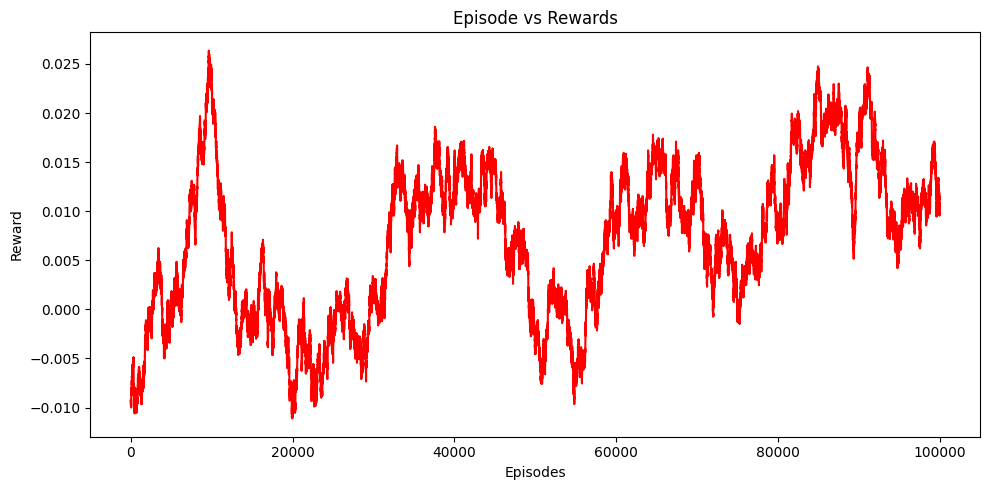

In [27]:
# Plot the reward moving average
length_step = 10000
reward_moving_average = (np.convolve(np.array(environment.rewards).flatten(), np.ones(length_step), mode="valid") / length_step)
plt.figure(figsize=(10, 5))
plt.title('Episode vs Rewards')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(range(len(reward_moving_average)), reward_moving_average, color='red')
plt.tight_layout()
plt.show()

In [28]:
for key, vals in policy.items():
   if(vals== 'd'):
         print(key, vals)

(10, 5, False, False) d
(12, 7, True, False) d
(21, 8, True, False) d
(11, 4, False, False) d
(11, 7, False, False) d
(10, 4, False, False) d
(10, 7, False, False) d
(21, 11, True, False) d
(11, 6, False, False) d
(21, 5, True, False) d
(15, 3, True, False) d
(21, 9, True, False) d
(11, 5, False, False) d
(15, 5, True, False) d
(11, 3, False, False) d
(11, 2, False, False) d
(14, 4, False, False) d
(16, 5, True, False) d
(10, 6, False, False) d
(17, 2, True, False) d
(13, 5, True, False) d
(9, 4, False, False) d
(20, 4, True, False) d
(14, 5, True, False) d
(12, 5, True, False) d
(10, 2, False, False) d
(19, 4, True, False) d
(9, 6, False, False) d
(17, 6, True, False) d


In [29]:
# for key, vals in policy_RV.items():
#    if(vals== 'd'):
#          print(key, vals)

#print(policy_RV.values('d'))
print(policy_RV)


{(20, 5, False, False): 's', (16, 3, False, False): 'h', (12, 4, False, False): 'h', (16, 2, True, False): 'h', (16, 2, False, False): 'h', (10, 5, False, False): 'd', (18, 10, False, False): 'h', (19, 7, False, False): 's', (9, 10, False, False): 'h', (17, 10, False, False): 'h', (12, 10, False, False): 's', (13, 10, False, False): 's', (19, 10, False, False): 'h', (12, 5, False, False): 's', (14, 3, False, False): 'h', (15, 3, False, False): 'h', (18, 9, False, False): 'h', (13, 5, False, False): 'h', (13, 11, False, False): 's', (16, 11, False, False): 's', (13, 3, False, False): 'h', (21, 10, False, False): 's', (10, 6, False, False): 'd', (13, 8, False, False): 's', (19, 4, False, False): 's', (20, 10, False, False): 's', (20, 7, False, False): 's', (12, 3, False, False): 's', (20, 3, False, False): 's', (20, 8, False, False): 's', (15, 6, False, False): 's', (10, 10, False, False): 'h', (12, 9, False, False): 's', (19, 9, False, False): 's', (8, 5, False, False): 'h', (14, 10, Fa

SARSA

In [80]:
#SARSA - change in update rule
class SARSAAgent:
    def __init__(self, environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, alpha, gamma):
        # initialize the SARSA agent with the given environment and learning parameters
        self.environment = environment
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = initial_epsilon
        self.initial_epsilon = initial_epsilon  # exploration rate
        self.num_episodes = num_episodes  # number of episodes to train
        self.epsilon_decay = epsilon_decay  # decay rate for epsilon
        self.final_epsilon = final_epsilon
        self.Q_values = {}  # Q-value dictionary mapping (state, action) pairs to Q-values
        self.epsilon_values = []
        self.action_counts = {'h': 0, 's': 0, 'd': 0}
        self.q_table = {}
        

     # Method to extract the policy
    def get_policy(self):
        """
        Derive the policy from the Q-table by selecting the best action for each state.
        """
        policy = {}

        # Ensure the Q-table is populated
        if not hasattr(self, "q_table") or not self.q_table:
            raise ValueError("Q-table is not initialized or empty. Ensure Q-values are populated.")

        for state, actions in self.q_table.items():
            if actions:  # Ensure there are actions to evaluate
                # Find the action with the highest Q-value
                best_action = max(actions, key=actions.get)
                policy[state] = best_action
            else:
                # Handle states with no available actions
                policy[state] = None  # No action is possible

        return policy

    
    def get_q_table(self):
        """
        Generate a Q-table organized by state and actions from the Q-values dictionary.
        """
        for (state, action), q_value in self.Q_values.items():
            if state == 'terminal':  # Skip terminal states
                continue
            if state not in self.q_table:
                self.q_table[state] = {a: 0.0 for a in ['h', 's', 'd']} 
            self.q_table[state][action] = q_value

    




    def get_q_value(self, state, action):
        # get the Q-value for a given state-action pair
        return self.Q_values.get((state, action), 0)
    
    def select_action(self, state):
        # choose an action to take in the given state based on the current Q-values and exploration rate
         if np.random.random() < self.epsilon:
            action = random.choice(['h', 's','d'])
         else:
            action =  max(['h', 's','d'], key=lambda action: self.Q_values.get((state, action), 0))
         
         self.action_counts[action] += 1  # Increment the count for the selected action
         return action    

    def update_q_value(self, state, action, next_state, next_action, reward):
        # Get the current Q-value for the given state-action pair
        current_q = self.Q_values.get((state, action), 0)

        # Get the Q-value for the next state and the next action
        # This is the key difference from Q-learning, where we consider the Q-value of the next action
        next_q = self.Q_values.get((next_state, next_action), 0)
        temporal_difference = reward + self.gamma * next_q - current_q
        self.Q_values[(state, action)] = current_q + self.alpha * temporal_difference

    
    def decay_epsilon(self, num_episode):
        # decay the epsilon value to reduce exploration over time
        self.epsilon = max(self.final_epsilon, self.initial_epsilon * (self.epsilon_decay ** num_episode))
    
    
    def train_agent(self, num_episodes):
        # train the SARSA agent by running the algorithm for the specified number of episodes
         for episode in range(num_episodes):
            self.environment.reset_game()
            state = self.environment.get_current_state()
            action = self.select_action(state)
            done = False
            while not done:
                next_state, reward, done = self.environment.step(action)
                next_action = self.select_action(next_state)
                self.update_q_value(state, action, next_state, next_action, reward)
                state = next_state  
                action = next_action
            
            self.decay_epsilon(num_episode= episode)  # Decay epsilon after each episode
            self.epsilon_values.append(self.epsilon)
         print("Action Counts:", self.action_counts)

    def train_agent_HP(self, num_episodes):
            rewards = []  # Track rewards
            for episode in range(num_episodes):
                  self.environment.reset_game()
                  state = self.environment.get_current_state()
                  action = self.select_action(state)
                  done = False
                  while not done:
                        next_state, reward, done = self.environment.step(action)
                        rewards.append(reward)
                        next_action = self.select_action(next_state)
                        self.update_q_value(state, action, next_state, next_action, reward)
                        
                        state = next_state  
                        action = next_action
                  self.decay_epsilon(num_episode= episode)
                  self.epsilon_values.append(self.epsilon)
            if rewards:  
                  return sum(rewards) / len(rewards)  # Average reward
            else:
                  return 0.0  # Return a default value if no rewards


Hyper parameter tuning: SARSA

In [84]:


# Hyperparameters
num_episodes = 100000
initial_epsilon = 1.0
environment = BlackjackEnvironment()

def objective(trial):
    # Suggest hyperparameters
    final_epsilon = trial.suggest_float("epsilon", 0.05, 0.1, log=True)
    learning_rate = trial.suggest_float("alpha", 0.01, 0.5, log=True)
    discount_factor = trial.suggest_float("gamma", 0.5, 1.0)

    epsilon_decay = (final_epsilon / initial_epsilon) ** (1 / num_episodes)

    # Initialize the Q-learning agent
    agent = SARSAAgent(
        environment=environment,
        num_episodes=num_episodes,
        initial_epsilon=initial_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
        alpha=learning_rate,
        gamma=discount_factor,
    )

    # Train the agent and calculate average reward
    average_reward = agent.train_agent_HP(num_episodes)
    return average_reward


start = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
end = time.time()


print("Optimization completed in {:.2f} seconds.".format(end - start))
print("Best parameters:", study.best_params)


[I 2025-01-18 14:54:46,995] A new study created in memory with name: no-name-980410cd-e865-44e6-8951-ac6e86b2da09
[I 2025-01-18 14:54:50,575] Trial 0 finished with value: -0.1763863287250384 and parameters: {'epsilon': 0.07538414463345497, 'alpha': 0.27347315880596534, 'gamma': 0.9975569563722725}. Best is trial 0 with value: -0.1763863287250384.
[I 2025-01-18 14:54:54,101] Trial 1 finished with value: -0.16165808715546692 and parameters: {'epsilon': 0.08980831038562112, 'alpha': 0.0490544219128487, 'gamma': 0.9868704339347816}. Best is trial 1 with value: -0.16165808715546692.
[I 2025-01-18 14:54:57,631] Trial 2 finished with value: -0.1588643971934759 and parameters: {'epsilon': 0.09893190884899168, 'alpha': 0.047945356131034365, 'gamma': 0.7613151516720484}. Best is trial 2 with value: -0.1588643971934759.
[I 2025-01-18 14:55:01,175] Trial 3 finished with value: -0.13662351075209325 and parameters: {'epsilon': 0.052791091058631716, 'alpha': 0.03506117161870935, 'gamma': 0.5743327411

Optimization completed in 176.46 seconds.
Best parameters: {'epsilon': 0.05027826788413271, 'alpha': 0.02785245521472777, 'gamma': 0.5484400129288652}


In [101]:
# training
start = time.time()
num_episodes = 100000

learning_rate =0.02785245521472777
discount_factor =  0.5484400129288652
initial_epsilon = 1.0
final_epsilon = 0.05027826788413271
epsilon_decay = (final_epsilon / initial_epsilon) ** (1 / num_episodes)

# Initialize the environment and the SARSA agent
environment = BlackjackEnvironment()
agent = SARSAAgent(environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, learning_rate,discount_factor)
agent.train_agent(num_episodes)

# evaluate the performance of the trained agent over a number of games
num_games = 10000
win_count = 0
loss_count = 0
draw_count = 0
total_reward = 0

for _ in range(num_games):
    agent.environment.reset_game()
    state = agent.environment.get_current_state()
    game_done = False

    while not game_done:
        action = agent.select_action(state)
        state, reward, game_done = agent.environment.step(action)
        total_reward += reward
    if reward > 0:
        win_count += 1
    elif reward < 0:
        loss_count += 1
    else:
        draw_count += 1

end = time.time()
print(f"Total time: {end-start:0.2f} seconds")

winning_rate = win_count / num_games
losing_rate = loss_count / num_games
draw_rate = draw_count / num_games

print(f"Basic Strategy - SARSA - Winning rate: {winning_rate:.4f}, Losing rate: {losing_rate:.4f}, Draw rate: {draw_rate:.4f}")

Action Counts: {'h': 130622, 's': 72949, 'd': 31363}
Total time: 4.12 seconds
Basic Strategy - SARSA - Winning rate: 0.4264, Losing rate: 0.4898, Draw rate: 0.0838


In [100]:
agent.get_q_table()
policy = agent.get_policy()
print(policy)
print(len(policy))

{(16, 11, False, False): 's', (18, 2, False, False): 's', (17, 9, False, False): 's', (21, 7, True, False): 's', (15, 10, True, False): 'h', (20, 10, False, False): 's', (14, 10, False, False): 'h', (21, 10, False, False): 's', (13, 11, False, False): 'h', (15, 11, False, False): 'h', (20, 11, False, False): 's', (21, 10, True, False): 's', (11, 9, False, False): 'd', (11, 7, False, False): 'd', (20, 8, False, False): 's', (7, 2, False, False): 'h', (14, 9, False, False): 'h', (16, 7, False, False): 's', (19, 8, False, False): 's', (14, 7, False, False): 's', (15, 7, False, False): 'h', (12, 5, False, False): 's', (8, 7, False, False): 'h', (15, 10, False, False): 'h', (15, 6, False, False): 's', (19, 10, False, False): 's', (11, 2, False, False): 'd', (13, 3, False, False): 'h', (13, 2, False, False): 'h', (18, 3, False, False): 's', (17, 2, False, False): 's', (12, 9, True, False): 'h', (21, 5, True, False): 's', (12, 10, False, False): 'h', (13, 4, False, False): 's', (17, 6, False,

Monte carlo - on policy

In [41]:
def epsilon_greedy_action(state, Q, epsilon=0.1):
    """
    Picks an action epsilon-greedily from Q-values for a given state.
    """
    actions = ['h', 's', 'd']  
    # With probability epsilon, choose a random action
    if np.random.rand() < epsilon:
        return random.choice(actions)
    best_action = None
    best_q = float('-inf')
    
    for a in actions:
        q_val = Q.get((state, a), 0.0)
        if q_val > best_q:
            best_q = q_val
            best_action = a
    return best_action

def monte_carlo_control(env, num_episodes=10000, gamma=1.0, epsilon=0.1):
    """
    Monte Carlo Control to learn an optimal policy for Blackjack.
    
    Args:
        env: BlackjackEnvironment instance
        num_episodes: number of episodes to sample
        gamma: discount factor (usually 1.0 for episodic Blackjack)
        epsilon: exploration rate for epsilon-greedy policy
        
    Returns:
        Q: dictionary of state-action values
        policy: derived from Q (greedy w.r.t Q)
    """
    Q = dict()
    

    returns_sum_count = defaultdict(lambda: [0.0, 0]) 
    actions = ['h', 's', 'd']
    
    for episode_i in range(num_episodes):
        env.reset_game()
        episode = []
        state = env.get_current_state()
        done = False
        
        while not done:
            # Select an action via epsilon-greedy
            action = epsilon_greedy_action(state, Q, epsilon)
            next_state, reward, done = env.step(action)
            
            episode.append((state, action, reward))
            state = next_state
        
        # 2) Calculate the returns (G) going backwards
        G = 0.0
        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = gamma * G + r
            
            # Update returns_sum_count
            returns_sum_count[(s, a)][0] += G
            returns_sum_count[(s, a)][1] += 1
            
            # Update Q(s, a) to average of all returns for (s, a)
            Q[(s, a)] = returns_sum_count[(s, a)][0] / returns_sum_count[(s, a)][1]
            
    def policy(state):
        """
        Greedy policy from Q. 
        """
        best_a = None
        best_q_val = float('-inf')
        for a in actions:
            q_val = Q.get((state, a), 0.0)
            if q_val > best_q_val:
                best_q_val = q_val
                best_a = a
        return best_a
    
    return Q, policy


In [102]:
# Train the agent
env = BlackjackEnvironment()
start = time.time()
Q, learned_policy = monte_carlo_control(env, num_episodes=1500000, gamma=1.0, epsilon=0.1)

def evaluate_policy(env, policy, num_episodes=10000):
    wins, losses, draws = 0, 0, 0
    for _ in range(num_episodes):
        env.reset_game()
        state = env.get_current_state()
        done = False
        while not done:
            action = policy(state)  # purely greedy choice
            state, reward, done = env.step(action)
        
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1
    
    return wins / num_episodes, losses / num_episodes, draws / num_episodes

win_rate, loss_rate, draw_rate = evaluate_policy(env, learned_policy)
end = time.time()
print(f"Total time: {end-start:0.2f} seconds")
print(f"After MC training(on policy):")
print(f"Win Rate:  {win_rate:.4f}")
print(f"Loss Rate: {loss_rate:.4f}")
print(f"Draw Rate: {draw_rate:.4f}")


Total time: 55.50 seconds
After MC training(on policy):
Win Rate:  0.4434
Loss Rate: 0.4714
Draw Rate: 0.0852
